In [15]:
import torch
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.transforms import transforms
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torch.optim import SGD
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
#from engine import train_one_epoch, evaluate

import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.transforms import functional as F
from torch.utils.data import Dataset, DataLoader
import json
from PIL import Image

In [16]:
import cv2
from IPython.display import display, Image

def draw_annotation(image_path, annotation):
    # Load the image
    image = cv2.imread(image_path)
    
    # Extract the annotation details
    filename = annotation["FileName"]
    annotations = annotation["Annotations"]
    
    # Process each annotation
    for annot in annotations:
        bounding_box = annot["BoundingBox"]
        class_name = annot["classname"]
        
        # Draw the bounding box
        x_min, y_min, x_max, y_max = bounding_box
        print(x_min, y_min, x_max, y_max)
        cv2.rectangle(image, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        
        # Add the class label
        text = f"{class_name}"
        cv2.putText(image, text, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        #make a dot at x_min, y_min and x_max, y_max
        cv2.circle(image, (x_min, y_min), 5, (0, 0, 255), -1)
        cv2.circle(image, (x_max, y_max), 5, (255, 0, 0), -1)
    
    # Save the image with annotations
    annotated_image_path = "annotated_image.jpg"
    cv2.imwrite(annotated_image_path, image)
    
    # Display the image in the notebook
    display(Image(filename=annotated_image_path))


{'FileName': '1861.jpg', 'NumOfAnno': 3, 'Annotations': [{'isProtected': False, 'ID': 999198335109255808, 'BoundingBox': [518, 116, 938, 632], 'classname': 'face_other_covering', 'Confidence': 1, 'Attributes': {}}, {'isProtected': False, 'ID': 211797538039653280, 'BoundingBox': [582, 126, 582, 126], 'classname': 'face_with_mask_incorrect', 'Confidence': 1, 'Attributes': {}}, {'isProtected': False, 'ID': 248677733460168320, 'BoundingBox': [542, 300, 932, 613], 'classname': 'mask_colorful', 'Confidence': 1, 'Attributes': {}}]}
518 116 938 632
582 126 582 126
542 300 932 613


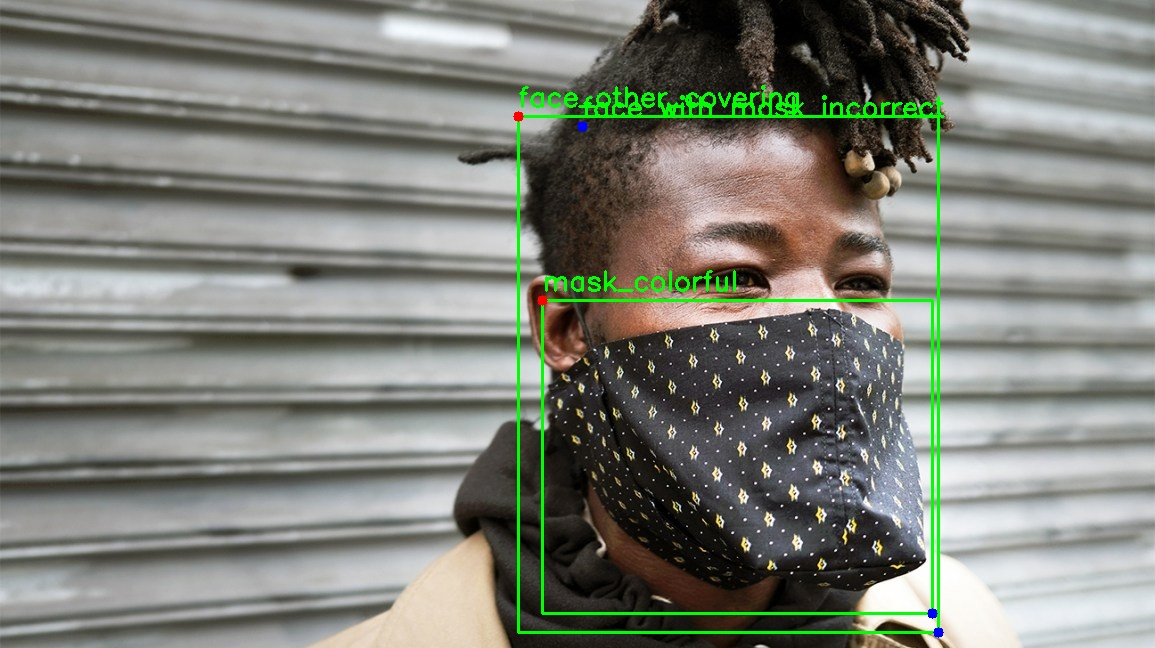

In [17]:
number = 1861


image_path = "C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask\images\\{number}.jpg".format(number=number)

#read json file
import json
with open('C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask\\annotations\\{number}.jpg.json'.format(number=number)) as json_file:
    annotation = json.load(json_file)

print(annotation)

draw_annotation(image_path, annotation)

In [4]:
#open the json file at Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\meta.json

import json
with open('C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\meta.json') as json_file:
    meta = json.load(json_file)

#copunt the entries in classes
print(len(meta["classes"]))

20


In [5]:
#iterate through all annotation files and search for invalid bounding boxes
import os
import json
from PIL import Image

# Get the path to the annotations
annotations_path = "C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask\\annotations"

# Get the path to the images
images_path = "C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask\images"

# Get the list of all annotations
annotation_files = os.listdir(annotations_path)


# Iterate through each annotation file
for annotation_file in annotation_files:
    # Build the path to the annotation file
    annotation_file_path = os.path.join(annotations_path, annotation_file)
    
    # Open the annotation file
    with open(annotation_file_path) as file:
        # Load the annotation file
        annotation = json.load(file)
        
        # Get the image filename
        image_filename = annotation["FileName"]
        
        # Build the path to the image file
        image_file_path = os.path.join(images_path, image_filename)
        
        # Open the image
        image = Image.open(image_file_path)
        
        # Get the image size
        image_width, image_height = image.size
        
        # Get the list of annotations
        annotations = annotation["Annotations"]
        
        # Iterate through each annotation
        for annotation in annotations:
            # Get the bounding box coordinates
            x_min = annotation["BoundingBox"][0]
            y_min = annotation["BoundingBox"][1]
            x_max = annotation["BoundingBox"][2]
            y_max = annotation["BoundingBox"][3]

            print(x_min, x_max, y_min, y_max)
            
            # Check if any coordinate exceeds the image boundaries
            if x_min > image_width or y_min > image_height or x_max > image_width or y_max > image_height:
                print("Invalid bounding box coordinates in file:", image_file_path)
                break

            if x_min > x_max or y_min > y_max:
                print("Invalid bounding box coordinates in file:", image_file_path)
                break

451 895 186 697
110 273 71 272
160 268 151 265
126 303 75 333
147 288 200 320
112 262 113 307
127 243 194 293
728 853 180 336
737 831 249 320
703 877 164 277
509 617 184 313
545 610 233 298
546 611 216 252
700 1802 165 1525
734 1958 4 635
80 882 243 1158
3 338 650 1374
915 1419 78 742
99 233 212 373
363 478 189 343
581 693 198 317
773 863 228 338
875 954 231 328
915 949 264 290
646 691 217 246
884 925 279 316
789 851 289 328
607 672 247 308
395 467 274 329
109 217 285 362
435 583 83 276
636 711 47 133
465 581 52 189
468 537 123 194
636 691 86 137
636 679 78 107
241 292 102 169
240 271 130 164
91 148 125 183
157 190 124 173
910 936 143 178
203 590 56 552
260 484 133 426
196 737 125 852
382 511 47 244
339 517 27 249
401 483 118 150
405 502 110 155
141 368 128 422
162 325 273 412
328 433 100 237
745 1228 1083 1713
696 1234 833 1251
518 623 137 259
432 523 104 214
130 227 136 240
140 215 166 236
438 509 148 209
527 597 184 248
25 51 111 140
510 708 2 213
521 679 89 200
518 718 1 50
386 545

In [11]:
import os
import PIL.Image as Image

class MaskDetectionDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
        self.annotations = []
        self.load_annotations()

    def load_annotations(self):
        annotation_files = os.listdir(f"{self.root_dir}/annotations")
        for file_name in annotation_files:
            with open(f"{self.root_dir}/annotations/{file_name}", "r") as f:
                annotation_data = json.load(f)
                annotations = annotation_data["Annotations"]
                file_name = annotation_data["FileName"]
                for annotation in annotations:
                    annotation["FileName"] = file_name
                self.annotations.extend(annotations)
                #chack the boxes are valid
                for annotation in annotations:
                    boxes = annotation["BoundingBox"]
                    if boxes[0] >= boxes[2] or boxes[1] >= boxes[3]:
                        print("Invalid bounding box coordinates in file:", file_name)
                        break

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        annotation = self.annotations[idx]
        image_path = f"{self.root_dir}/images/{annotation['FileName']}"
        image = Image.open(image_path).convert("RGB")

        # Convert bounding box coordinates to a format accepted by torchvision
        box = annotation["BoundingBox"]
        box = torch.tensor([box[0], box[1], box[2], box[3]], dtype=torch.float32)

        # Map class names to integer labels (e.g., 'face_with_mask' -> 1)
        class_name = annotation["classname"]
        class_label = 1 if class_name == "face_with_mask" else 0

        return {
            "image": image,
            "bbox": box,
            "label": class_label
        }




In [12]:
#PARAMETERS
BATCH_SIZE = 4
NUM_EPOCHS = 10
LEARNING_RATE = 0.005
TRAIN_PERCENTAGE = 0.3

In [13]:
dataset = MaskDetectionDataset("C:\GIT_Workspaces\Deep-Vision-sta\Datasets\Face Mask Detection Dataset\Medical mask\Medical mask\Medical Mask")


# Split the dataset into training and validation sets (adjust the split ratio as needed)
train_size = int(TRAIN_PERCENTAGE * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])


Invalid bounding box coordinates in file: 1861.jpg


In [9]:
dataset[0]

{'image': <PIL.Image.Image image mode=RGB size=1386x1385>,
 'bbox': tensor([451., 186., 895., 697.]),
 'label': 0}

In [10]:
for i in range(len(dataset)):
    #get image boxes and labels
    target = dataset[i]
    box = target['bbox']
    if box[0] >= box[2] or box[1] >= box[3]: # min x > max x or min y > max y
        print(i, box)

207 tensor([582., 126., 582., 126.])


KeyboardInterrupt: 

In [17]:
len(dataset)

15412

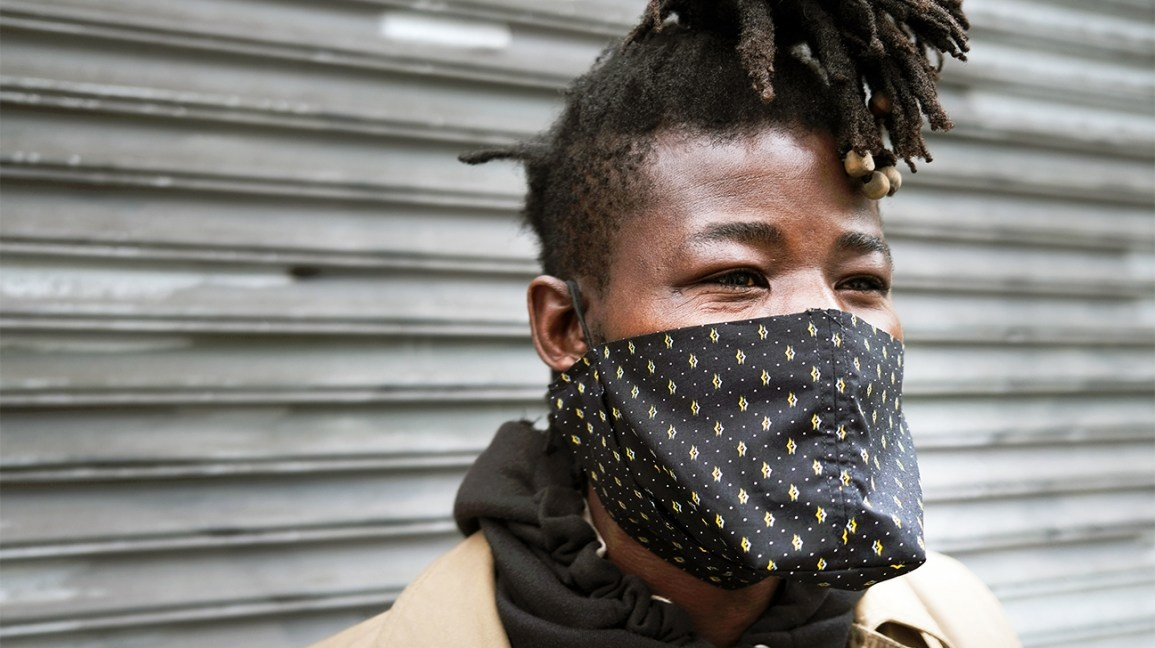

In [20]:
dataset[207][image]

In [8]:
def collate_fn(batch):
    images = [sample["image"] for sample in batch]
    targets = []
    for sample in batch:
        target = {}
        target["boxes"] = sample["bbox"].unsqueeze(0)
        target["labels"] = torch.tensor([sample["label"]], dtype=torch.int64)
        targets.append(target)
    return images, targets


In [9]:
train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)


In [10]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
num_classes = 20
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)


c:\Users\johan\.conda\envs\DV-STA\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\johan\.conda\envs\DV-STA\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=LEARNING_RATE, momentum=0.9, weight_decay=0.0005)

# Learning rate scheduler (optional)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

In [26]:
import time

def train(model, data_loader, optimizer, device):
    model.train()
    total_iterations = len(data_loader)
    start_time = time.time()
    for iteration, (images, targets) in enumerate(data_loader, 1):

        print(targets)
        images = [F.to_tensor(img).to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        losses.backward()
        optimizer.step()

        elapsed_time = time.time() - start_time
        avg_time_per_iteration = elapsed_time / iteration
        remaining_iterations = total_iterations - iteration
        eta = avg_time_per_iteration * remaining_iterations

        print(f"Iteration: {iteration}/{total_iterations}, Remaining: {remaining_iterations}, ETA: {eta:.2f} seconds, Loss: {losses:.4f}", end="\r")



def validate(model, data_loader, device):
    model.eval()
    total_loss = torch.tensor(0.0, device=device)  # Initialize total_loss as a tensor
    with torch.no_grad():
        for images, targets in data_loader:
            images = [F.to_tensor(img).to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())
            total_loss += losses.item()

    average_loss = total_loss / len(data_loader)
    return average_loss



In [27]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

device

device(type='cuda')

In [28]:
device

device(type='cuda')

In [29]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

In [30]:
num_epochs = 10  # Adjust the number of epochs as needed

for epoch in range(NUM_EPOCHS):
    train(model, train_data_loader, optimizer, device)
    val_loss = validate(model, val_data_loader, device)
    print(f"Epoch: {epoch+1}, Validation Loss: {val_loss}")


[{'boxes': tensor([[197., 154., 448., 350.]]), 'labels': tensor([0])}, {'boxes': tensor([[698.,  43., 859., 210.]]), 'labels': tensor([0])}, {'boxes': tensor([[ 91.,  98., 133., 150.]]), 'labels': tensor([0])}, {'boxes': tensor([[219., 145., 321., 173.]]), 'labels': tensor([0])}]


In [ ]:
dataset.__getitem__(1)

{'image': <PIL.Image.Image image mode=RGB size=612x408>,
 'bbox': tensor([110.,  71., 273., 272.]),
 'label': 1}

In [ ]:
torch.save(model.state_dict(), "mask_detection_model.pth")
